# Spotify history parser

## Exploration

In [196]:
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import re
from pathlib import Path
from datetime import date
from matplotlib.backends.backend_pdf import PdfPages

## Settings

In [197]:
start_date = date(2020, 1, 1)
end_date = date(2030,1, 1)

nrof_top_artists = 10
nrof_top_songs = 10

listening_time_per_day_rolling_window = 7
top_songs_rolling_window = 7
top_artists_rolling_window = 7

## Setup

In [198]:
pdf_pages = PdfPages('Wrapped.pdf')
df = pd.DataFrame()
directory = Path('.')
pattern = re.compile(r'StreamingHistory_music_\d+\.json')
for file_path in directory.iterdir():
    if file_path.is_file() and pattern.match(file_path.name):
        df = pd.concat([df, pd.read_json(file_path)])
df = df.drop_duplicates()

In [199]:
#df

In [200]:
df.dtypes

endTime       object
artistName    object
trackName     object
msPlayed       int64
dtype: object

In [201]:
df["endTime"] = pd.to_datetime(df["endTime"])
df["msPlayed"] = pd.to_numeric(df["msPlayed"])

In [202]:
df.dtypes

endTime       datetime64[ns]
artistName            object
trackName             object
msPlayed               int64
dtype: object

In [203]:
start_date = max(start_date, df["endTime"].min().date())
end_date = min(end_date, df["endTime"].max().date())

timeFrameDf = df.query(f"endTime >= '{start_date}' & endTime < '{end_date}'")
#timeFrameDf


In [204]:
df = timeFrameDf

## Front Page

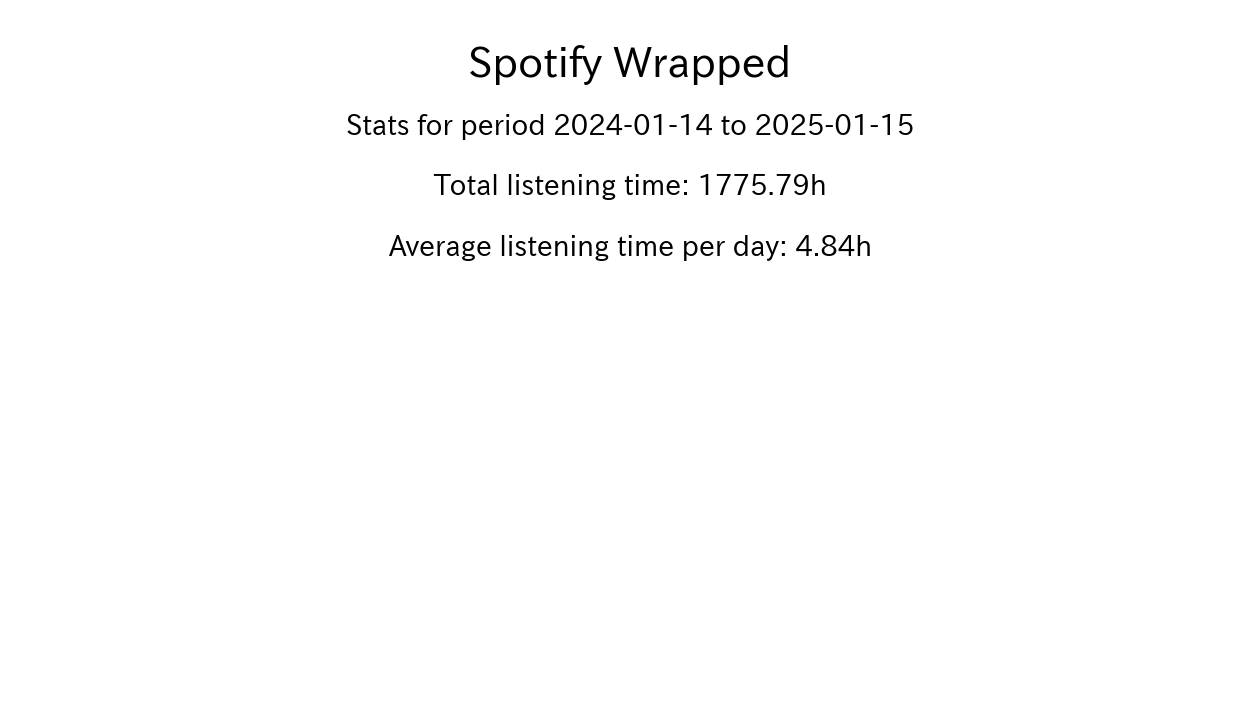

In [205]:
plt.figure(figsize=(16, 9))  # Standard letter size
plt.text(0.5, 0.95, 'Spotify Wrapped', fontsize=30, ha='center', va='top')
period = end_date - start_date
info_string = f"""Stats for period {start_date} to {end_date}\n
Total listening time: {(df["msPlayed"].sum() / 3600000).round(2)}h\n
Average listening time per day: {(df['msPlayed'].sum() / period.days / 3600000).round(2)}h\n"""

plt.text(0.5, 0.85, info_string, fontsize=20, ha='center', va='top')
plt.axis('off')  # Hide axes

# Save the text page to the PDF
pdf_pages.savefig()
plt.show()
plt.close()

## Top Songs

In [206]:
top_songs = df.groupby(["artistName", "trackName"])["msPlayed"].count().sort_values(ascending=False).rename("playCount").head(nrof_top_songs)
pd.DataFrame(top_songs)

playCount
artistName          trackName                      
Ryokuoushoku Shakai 花になって - Be a flower        4107
Creepy Nuts         よふかしのうた                    1084
                    Bling-Bang-Bang-Born       1052
美波                  カワキヲアメク                    1049
Creepy Nuts         堕天                         1046
fhána               Rhapsody of Blue Sky       1043
Hanae               神様はじめました                   1013
BRADIO              Flyers                      651
Black Gryph0n       Insane                      649
MindaRyn            Like Flames                 578

Index(['playCount'], dtype='object')


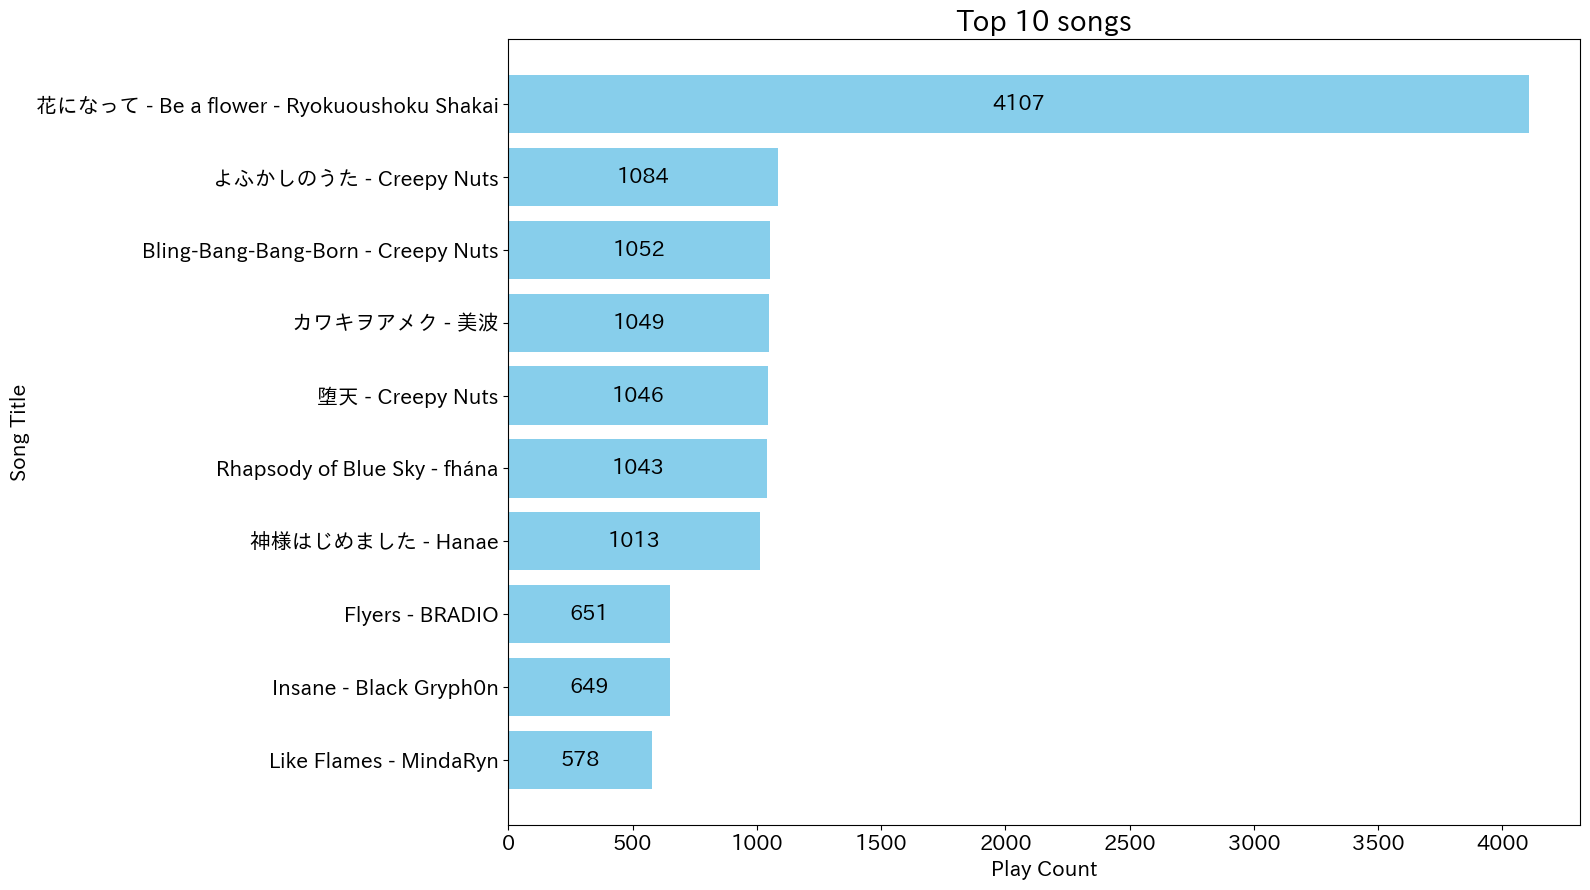

In [207]:

plt.figure(figsize=(16,9))

top_songs_df = pd.DataFrame(top_songs)
top_songs_df = top_songs_df.sort_values(by='playCount', ascending=True)
print(top_songs_df.columns)
plt.barh([str(i[1]) + " - " + str(i[0]) for i in top_songs_df.index], top_songs_df['playCount'] , color='skyblue')
for index, value in enumerate(top_songs_df['playCount']):
    plt.text(value / 2, index, f'{value}', ha='center', va='center', fontsize=15)


plt.title(f"Top {nrof_top_songs} songs", fontsize=20)
plt.ylabel("Song Title", fontsize=15)
plt.xlabel("Play Count", fontsize=15)

plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

plt.tight_layout()
pdf_pages.savefig()
plt.show()

In [208]:
top_songs_full = df[df.set_index(["artistName", "trackName"]).index.isin(top_songs.index)]
#top10_full

In [209]:
top_songs_daily = top_songs_full.groupby(["artistName", "trackName"]).resample("d", on="endTime").count()
top_songs_daily["playCount"] = top_songs_daily["artistName"]
top_songs_daily = top_songs_daily.drop(["artistName", "trackName", "msPlayed"], axis=1)
#top10_daily

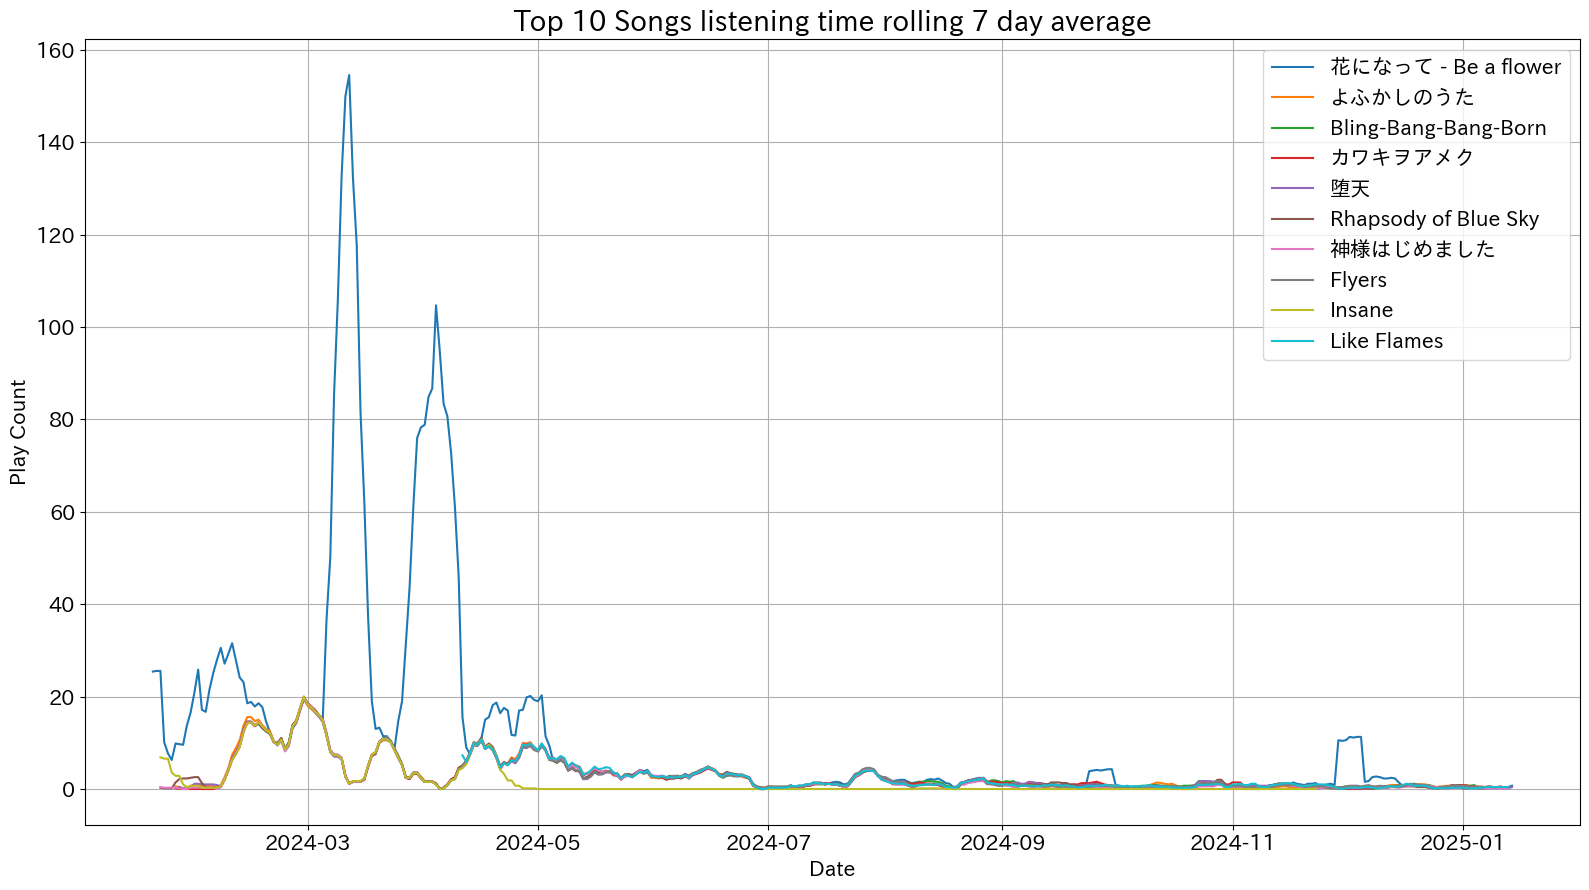

In [210]:
plt.figure(figsize=(16,9))

for artist, track in top_songs.index:
    song_data = top_songs_daily.query(f"artistName == '{artist}' & trackName == '{track}'").reset_index()
    song_data['rolling_playCount'] = song_data['playCount'].rolling(window=top_songs_rolling_window).mean()
    plt.plot(song_data["endTime"], song_data["rolling_playCount"], label=f"{track}")

plt.legend(fontsize=15)
plt.title(f"Top {nrof_top_songs} Songs listening time rolling {top_songs_rolling_window} day average", fontsize=20)
plt.xlabel("Date", fontsize=15)
plt.ylabel("Play Count", fontsize=15)
plt.grid()

plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

plt.tight_layout()
pdf_pages.savefig()
plt.show()

## Top artists

In [211]:
top_artists = df.groupby(["artistName"])["msPlayed"].count().sort_values(ascending=False).rename("playCount").head(nrof_top_artists)
pd.DataFrame(top_artists)

,playCount
artistName,
Ryokuoushoku Shakai,4530
Creepy Nuts,3793
Ado,2122
fhána,1107
Hanae,1091
美波,1066
BRADIO,682
Black Gryph0n,649
MindaRyn,608


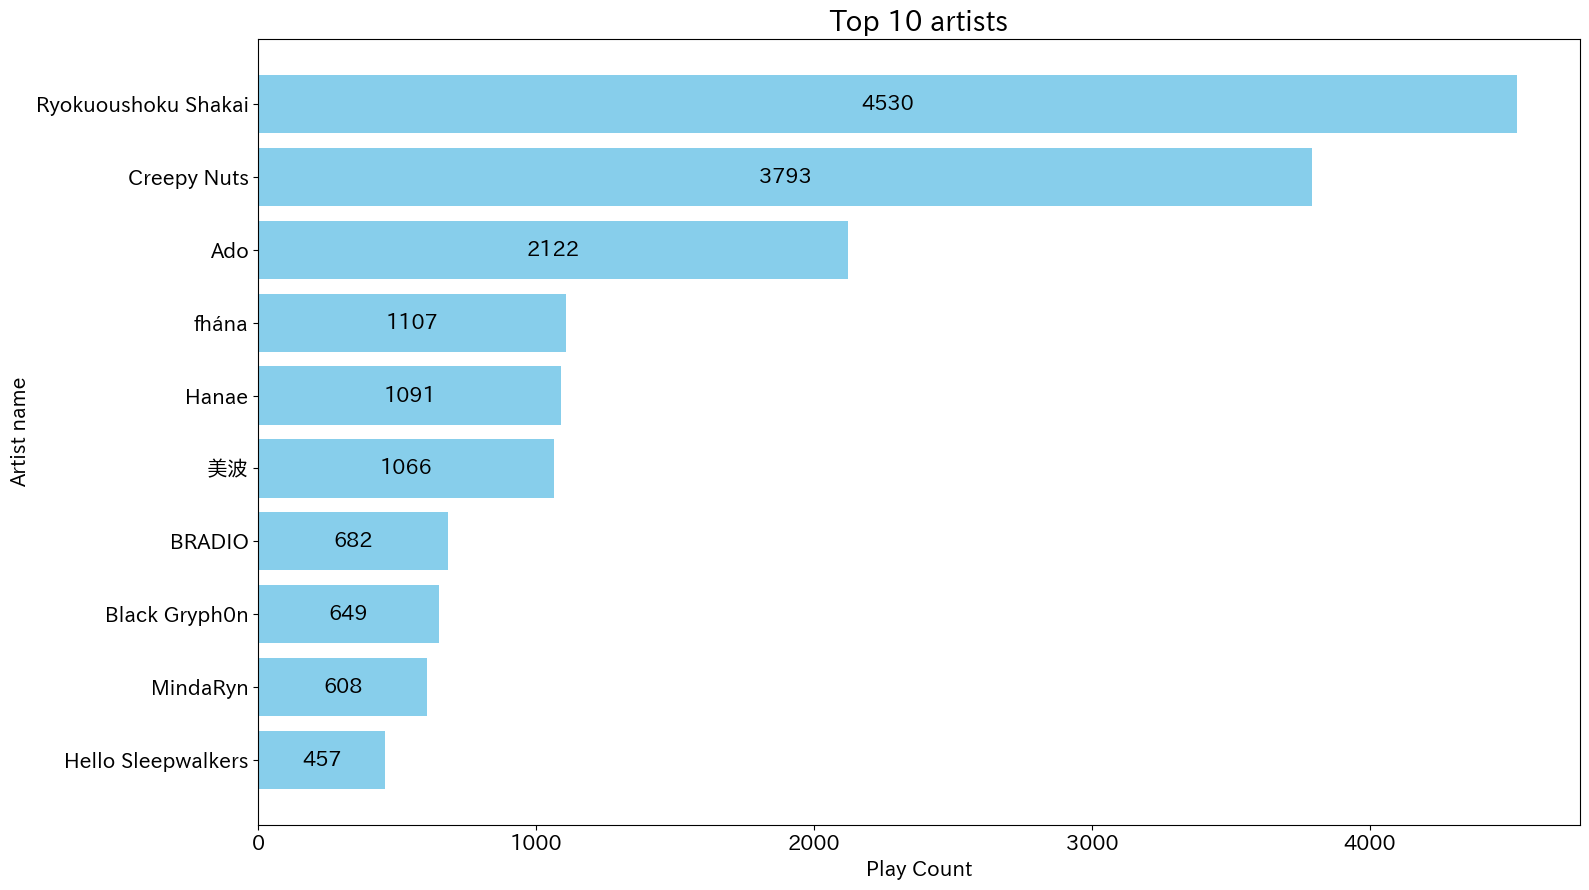

In [212]:
plt.figure(figsize=(16,9))

top_artist_df = pd.DataFrame(top_artists)

top_artist_df = top_artist_df.sort_values(by='playCount', ascending=True)

plt.barh(top_artist_df.index, top_artist_df['playCount'], color='skyblue')
for index, value in enumerate(top_artist_df['playCount']):
    plt.text(value / 2, index, f'{value}', ha='center', va='center', fontsize=15)

plt.title(f"Top {nrof_top_artists} artists", fontsize=20)
plt.ylabel("Artist name", fontsize=15)
plt.xlabel("Play Count", fontsize=15)

plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

plt.tight_layout()
pdf_pages.savefig()
plt.show()

In [213]:
top_artists_full = df[df.set_index(["artistName"]).index.isin(top_artists.index)]
#top5_artists_full

In [214]:
top_artists_daily = top_artists_full.groupby(["artistName"]).resample("D", on="endTime").count()
top_artists_daily["playCount"] = top_artists_daily["artistName"]
top_artists_daily = top_artists_daily.drop(["artistName", "trackName", "msPlayed"], axis=1)
#top5_artists_daily

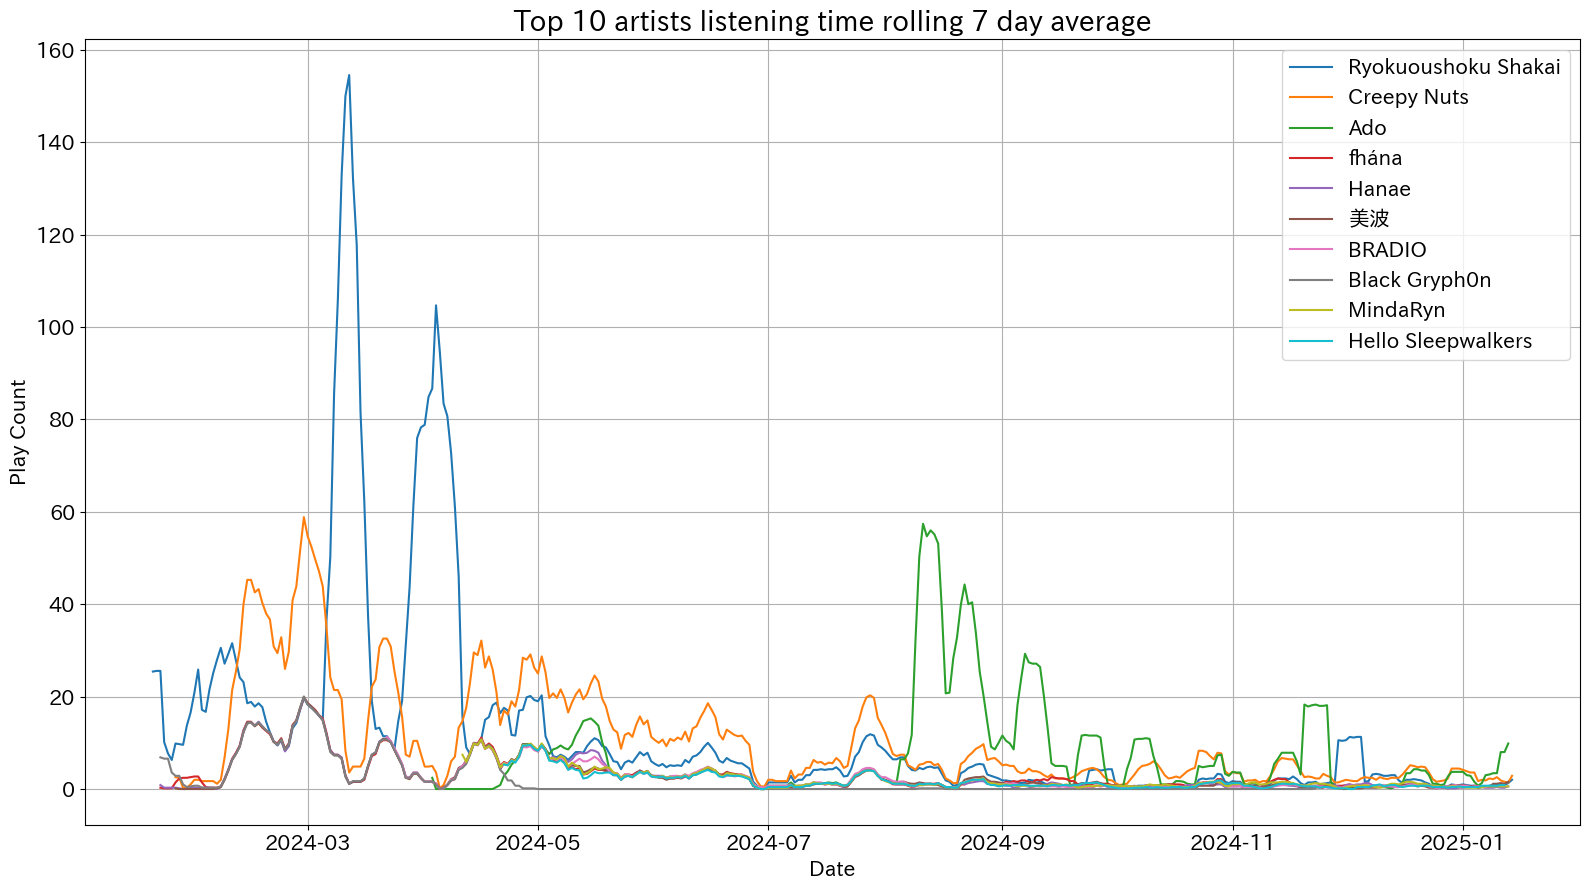

In [215]:
plt.figure(figsize=(16,9))

for artist in top_artists.index:
    song_data = top_artists_daily.query(f"artistName == '{artist}'").reset_index()
    song_data['rolling_playcount'] = song_data["playCount"].rolling(window=top_artists_rolling_window).mean()
    plt.plot(song_data["endTime"], song_data["rolling_playcount"], label=f"{artist}")


plt.legend(fontsize=15)

plt.title(f"Top {nrof_top_artists} artists listening time rolling {top_artists_rolling_window} day average", fontsize=20)
plt.xlabel("Date", fontsize=15)
plt.ylabel("Play Count", fontsize=15)
plt.grid()

plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

plt.tight_layout()
pdf_pages.savefig()
plt.show()

## Playtime

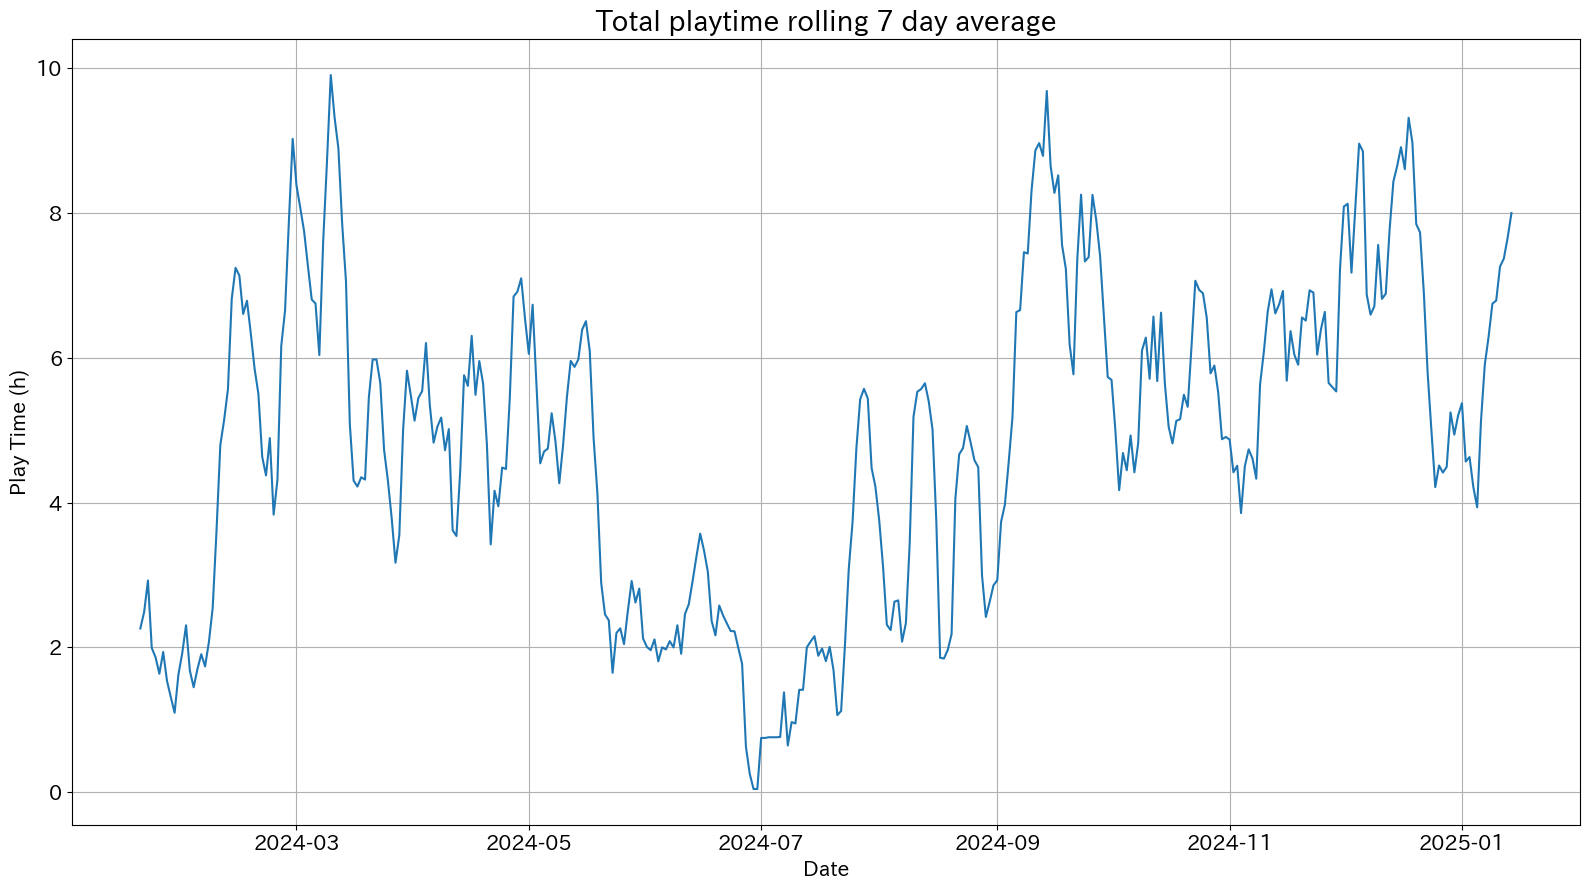

In [216]:
playtime = df.resample("D", on="endTime")["msPlayed"].sum()

# Convert to hours
playtime = playtime.divide(3600000)

playtime = playtime.rolling(window=listening_time_per_day_rolling_window).mean()

plt.figure(figsize=(16,9))
plt.plot(playtime)

plt.title(f"Total playtime rolling {listening_time_per_day_rolling_window} day average", fontsize=20)
plt.xlabel("Date", fontsize=15)
plt.ylabel("Play Time (h)", fontsize=15)

plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

plt.grid()

plt.tight_layout()
pdf_pages.savefig()
plt.show()

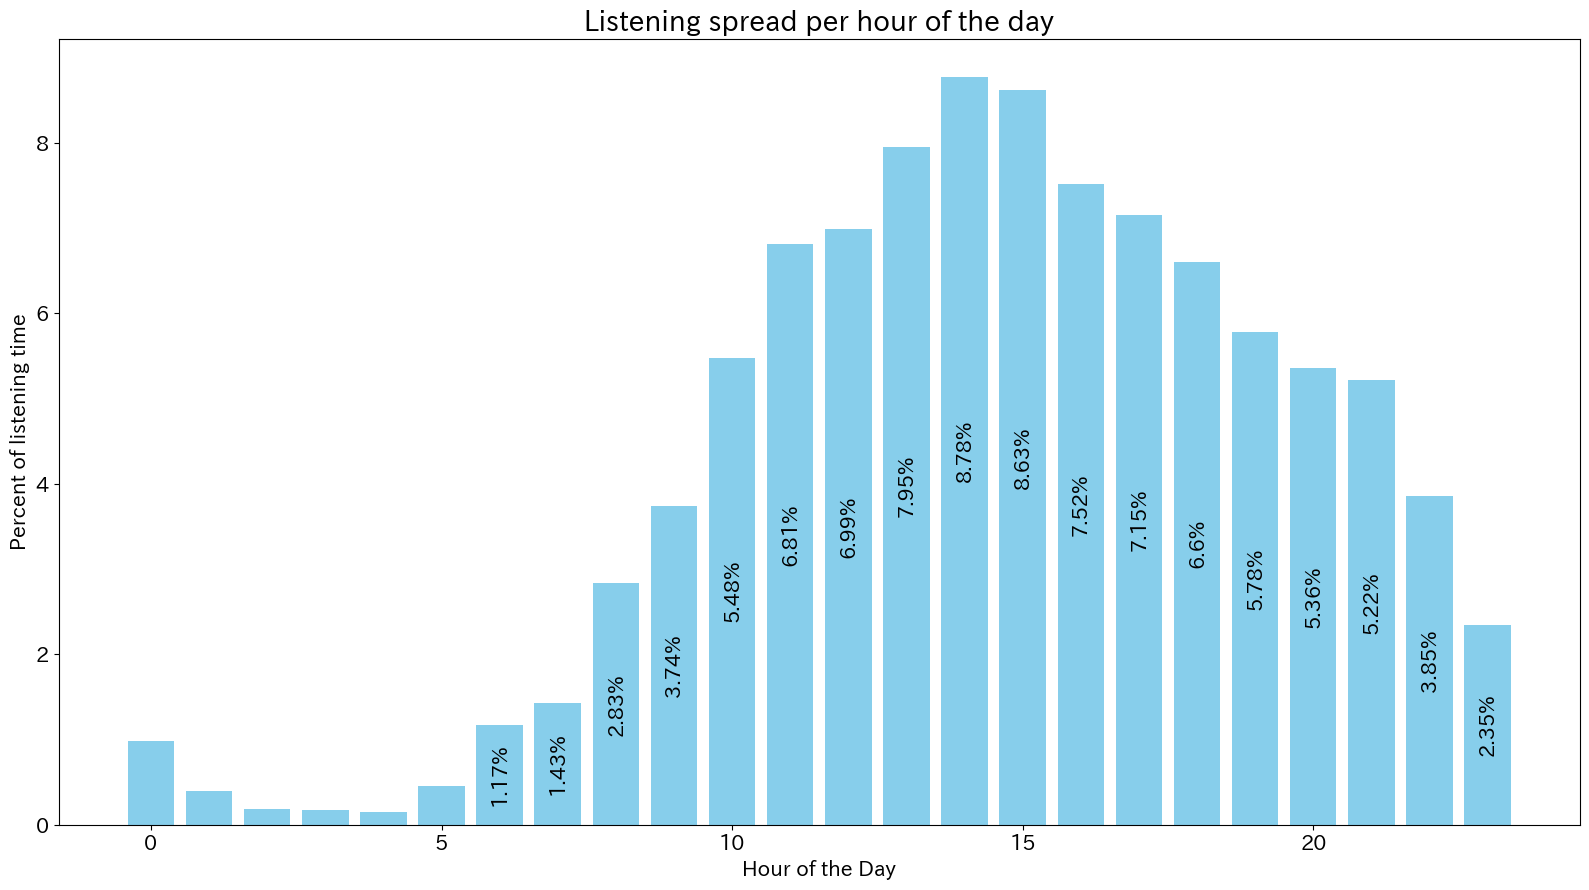

In [217]:
ms_per_hour = df
ms_per_hour['hours'] = df['endTime'].dt.hour
ms_per_hour = ms_per_hour.groupby('hours')['msPlayed'].sum()
ms_per_hour = ms_per_hour.reindex(range(24), fill_value=0)
total_listening_time = ms_per_hour.sum()
percent_occurrences_per_hour = (ms_per_hour / total_listening_time) * 100

plt.figure(figsize=(16, 9))
plt.bar(range(24), percent_occurrences_per_hour, color='skyblue')
for index, value in enumerate(percent_occurrences_per_hour):
   formatedValue = ''
   if (value > 1): formatedValue = f'{round(value, 2)}%'
   plt.text(index, value / 2, formatedValue, ha='center', va='center', fontsize=15, rotation=90)

plt.title('Listening spread per hour of the day', fontsize=20)
plt.xlabel('Hour of the Day', fontsize=15)
plt.ylabel('Percent of listening time', fontsize=15)

plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xticks(rotation=0)

plt.tight_layout()
pdf_pages.savefig()
plt.show()


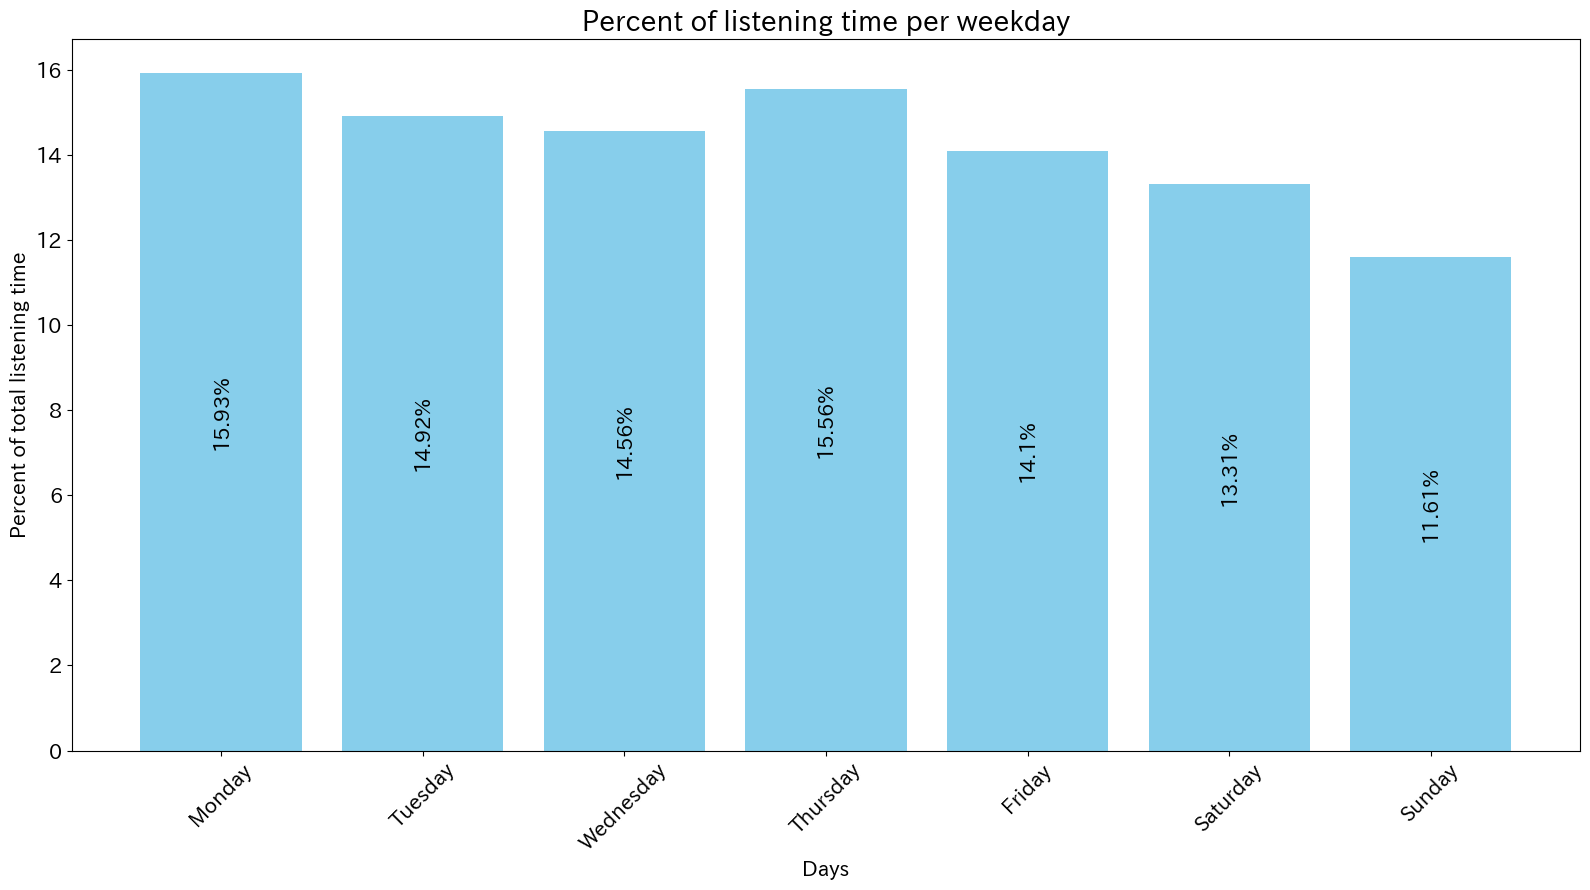

In [218]:
listen_time_weekday = df
listen_time_weekday['weekday'] = df['endTime'].dt.weekday
listen_time_weekday = listen_time_weekday.groupby('weekday')['msPlayed'].sum()
listen_time_weekday = listen_time_weekday.reindex(range(7), fill_value=0)

total_listening_time = listen_time_weekday.sum()
percent_occurrences_per_hour = (listen_time_weekday / total_listening_time) * 100

plt.figure(figsize=(16, 9))
plt.bar(range(7), percent_occurrences_per_hour, color='skyblue')
for index, value in enumerate(percent_occurrences_per_hour):
   formatedValue = ''
   if (value > 1): formatedValue = f'{round(value, 2)}%'
   plt.text(index, value / 2, formatedValue, ha='center', va='center', fontsize=15, rotation=90)


plt.title('Percent of listening time per weekday', fontsize=20)
plt.xlabel('Days', fontsize=15)
plt.ylabel('Percent of total listening time', fontsize=15)

plt.xticks(fontsize=15, ticks=[0,1,2,3,4,5,6], rotation=45, labels=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.yticks(fontsize=15)

plt.tight_layout()
pdf_pages.savefig()
pdf_pages.close()
plt.show()